# Network Analysis

This notebook covers the first half of the assessment on network analysis.

In [1]:
# import the necessary libraries
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import re
import shapely
from scipy.spatial import distance

## Construct the topological network

Based on the `tfl_stations.json` and `tfl_lines.json` files, we will create a network of the underground. The code for this part is largely adopted from the practical session.

In [2]:
# load data and project into British National Grid
stations = gpd.read_file(os.path.join('data', 'network', 'tfl_stations.json')).to_crs('EPSG:27700')
lines = gpd.read_file(os.path.join('data', 'network', 'tfl_lines.json')).to_crs('EPSG:27700')

### Edit stations data

In [3]:
# clean station names

# get all names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

# clean the names
for k, v in station_names.items():
    if k == 'none':
        continue
    # get rid of everything other than the name itself - like LU / LO / DLR / ( )
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)

    # combine Bank and Monument as 'Bank and Monument'
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name

# save back into the gdf
stations['name'] = stations['id'].apply(lambda x: station_names[x])

In [4]:
# change position of station to mean of all stations with the same name

pos = {}

for i, station in stations.iterrows():
    # store coordinates
    xy = station.geometry.coords[0]

    # if station already in dictionary, add coordinate to list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    # else add to list and set coordinate as first item in list
    else:
        pos[station['name']] = [xy]

# iterate through the dictionary to replace coordinate with the mean value
for k, v in pos.items():
    pos[k] = np.mean(v, axis = 0)

# set new geometry
stations['geometry'] = stations['name'].apply(lambda x: shapely.Point(pos[x]))

<Axes: >

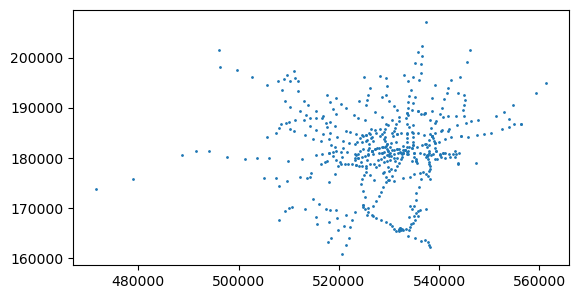

In [5]:
stations.plot(markersize = 1)

### Edit lines data

In [6]:
# get the line names
line_names = lines['lines'].apply(lambda x: [x['name'] for x in json.loads(x)])
line_names = list(set([item for sublist in line_names for item in sublist]))

# Rename the East London Line into the London Overground, as it is part of it
lines['lines'] = lines['lines'].str.replace('East London', 'London Overground')
stations['lines'] = stations['lines'].str.replace('East London', 'London Overground')

# remove the unnecessary lines
remove_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']
for r in remove_lines:
    line_names.remove(r)

line_names


['Circle',
 'Central',
 'Metropolitan',
 'TfL Rail',
 'Waterloo & City',
 'Northern',
 'District',
 'Piccadilly',
 'DLR',
 'Bakerloo',
 'Hammersmith & City',
 'Victoria',
 'Jubilee',
 'London Overground']

In [7]:
# # check the data for each line
# for line in line_names:
#     fig, ax = plt.subplots(figsize = (7,7))
#     fig.suptitle(f'line: {line}')
#     ax.set_aspect("equal")
#     ax.axis('off')
#     ax.margins(0.1)
#     temp_lines = lines[lines.lines.str.contains(line)]
#     base = temp_lines.plot(ax=ax)
#     temp_stations = stations[stations.lines.str.contains(line)]
#     temp_stations.plot(ax=base, markersize=20)
#     plt.show()

### Add geometry

Circle


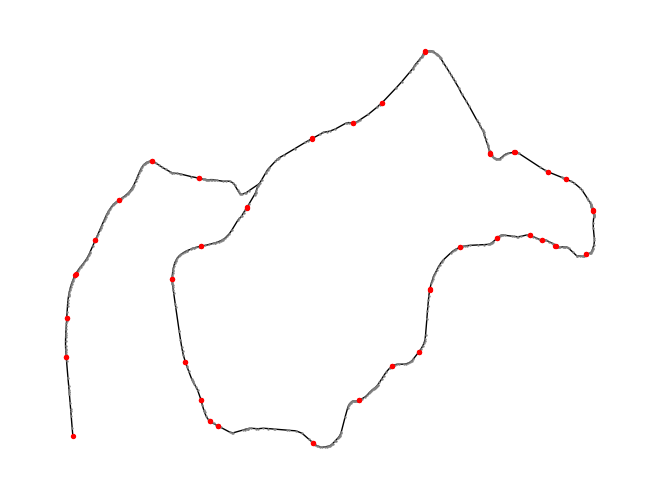

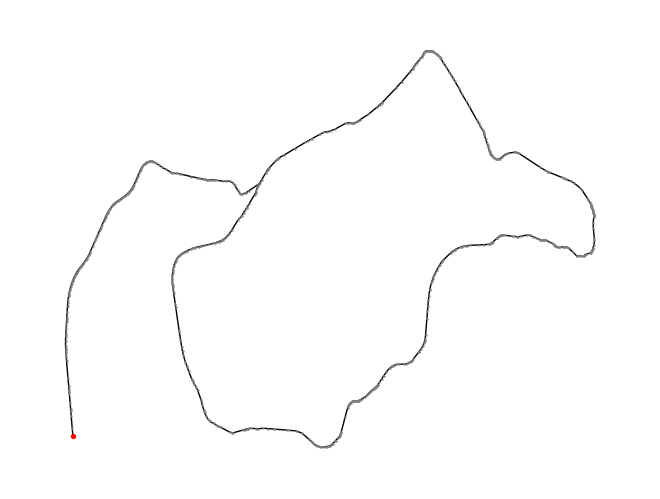

1
Central


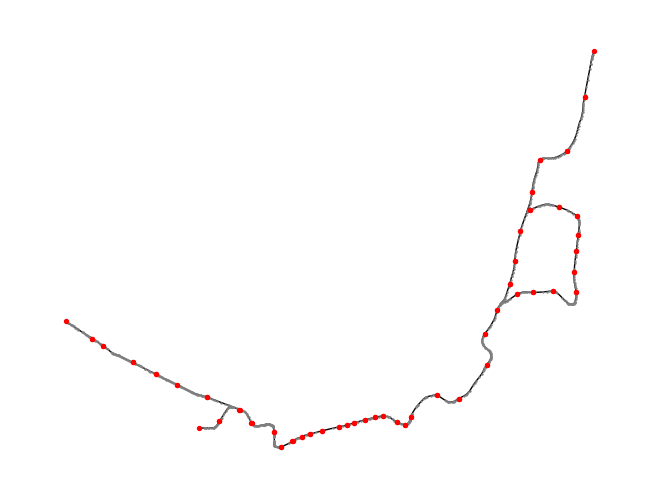

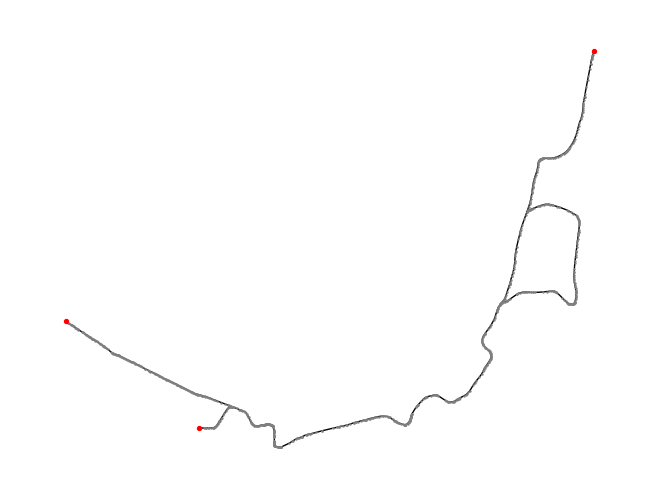

1
Metropolitan


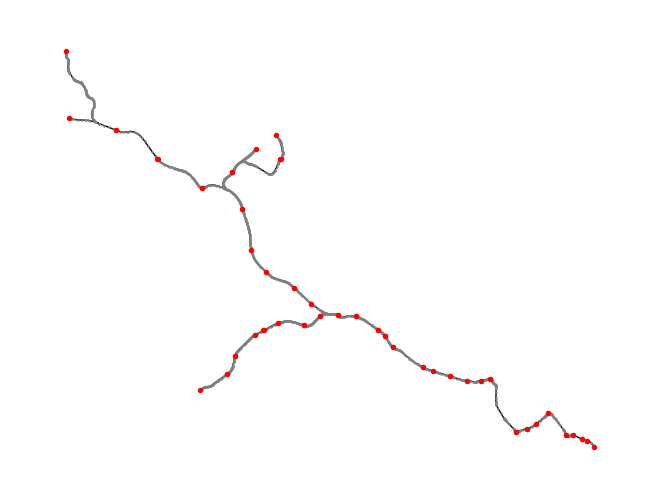

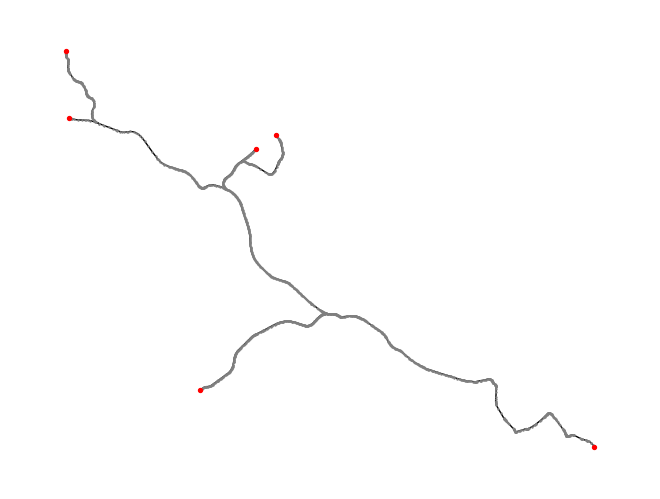

1
TfL Rail


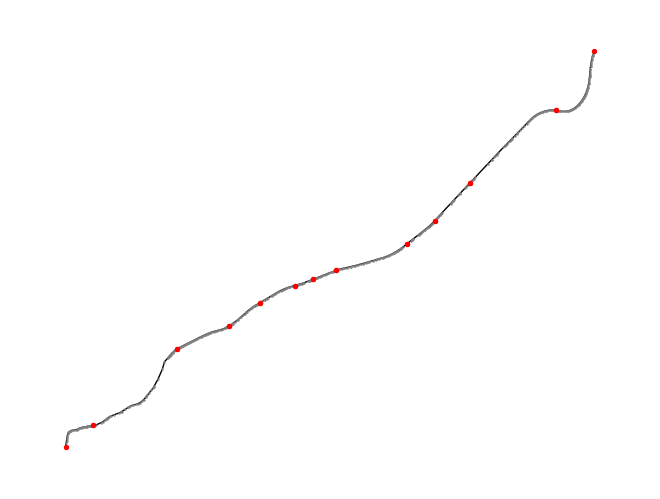

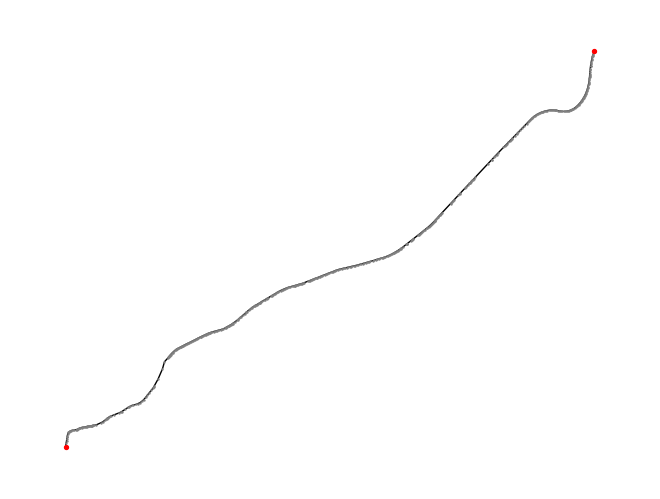

1
Waterloo & City


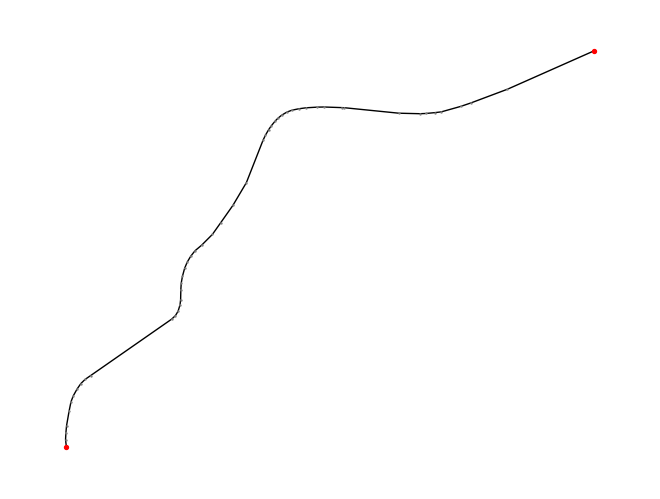

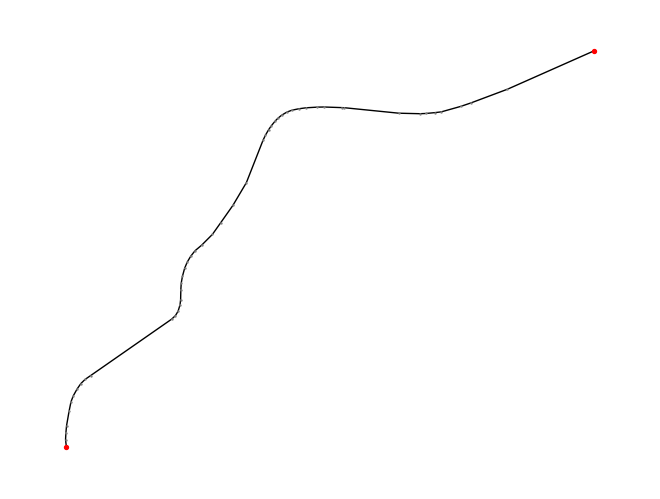

1
Northern


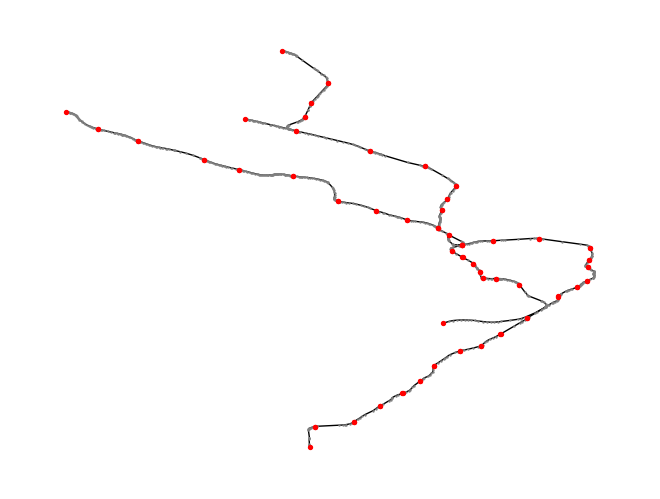

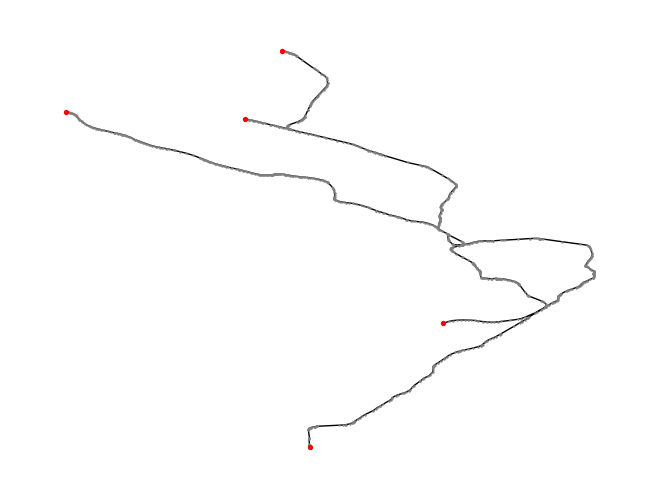

1
District


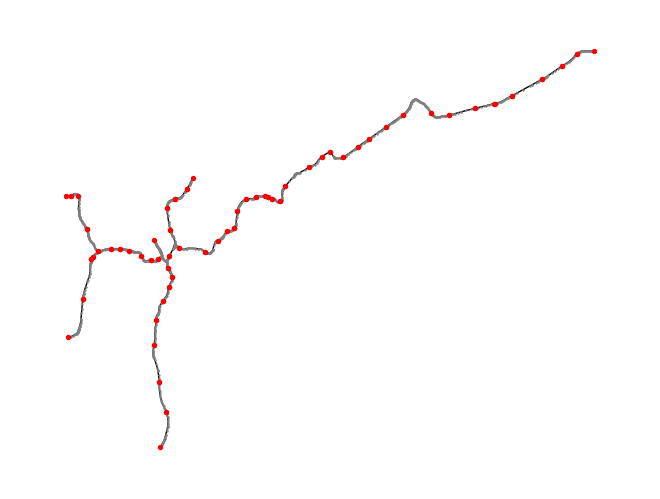

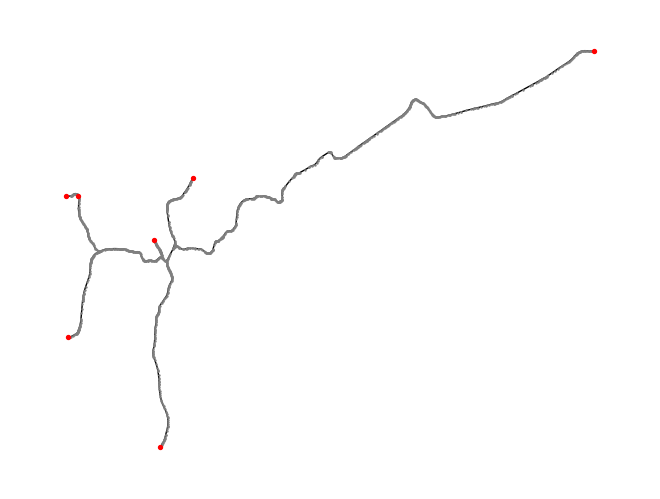

1
Piccadilly


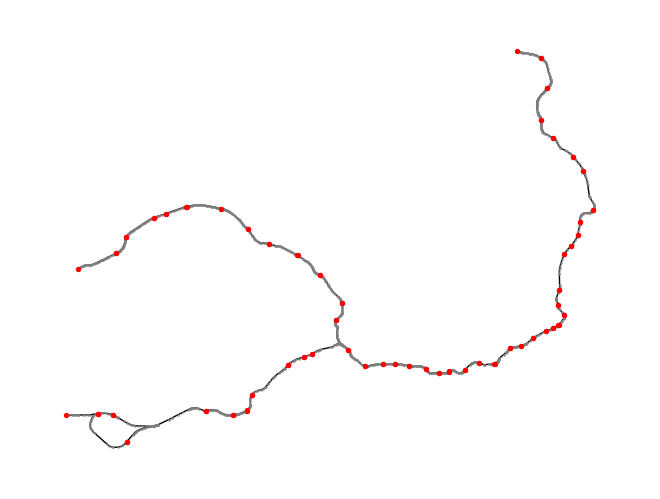

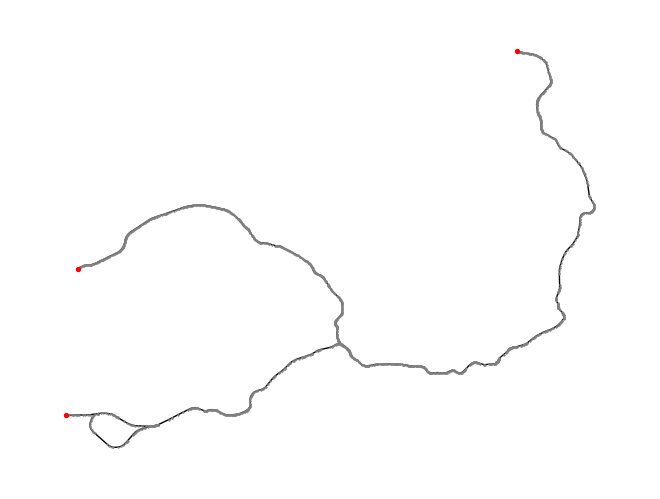

1
DLR


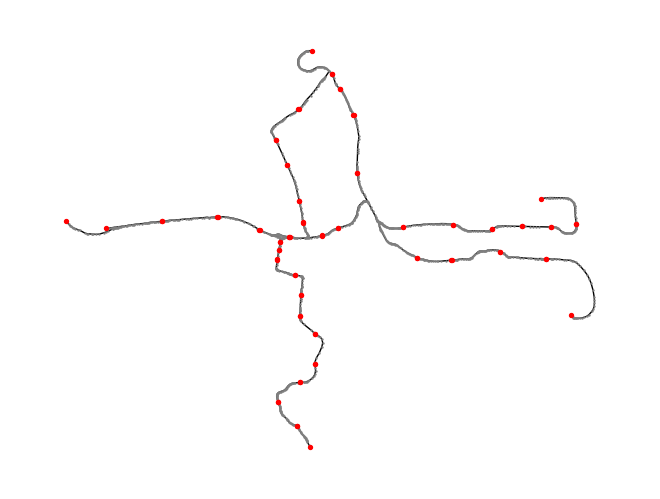

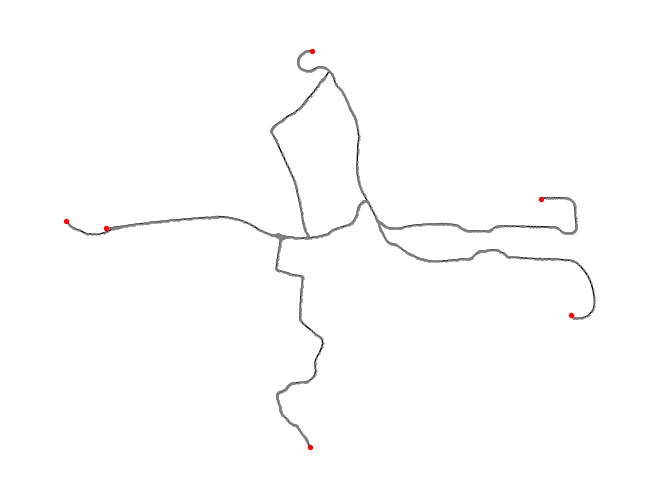

1
Bakerloo


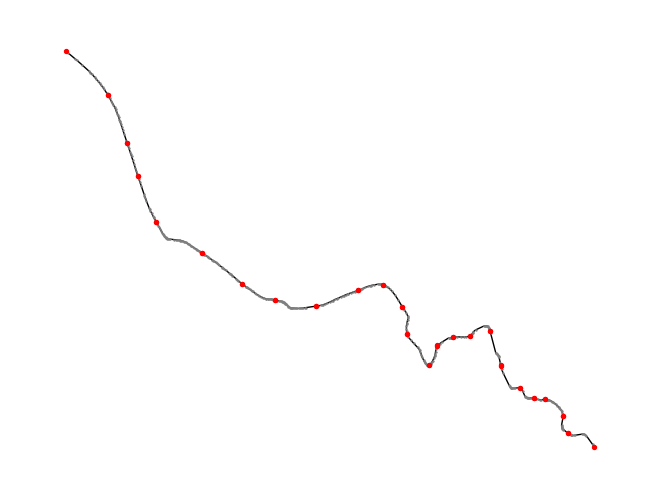

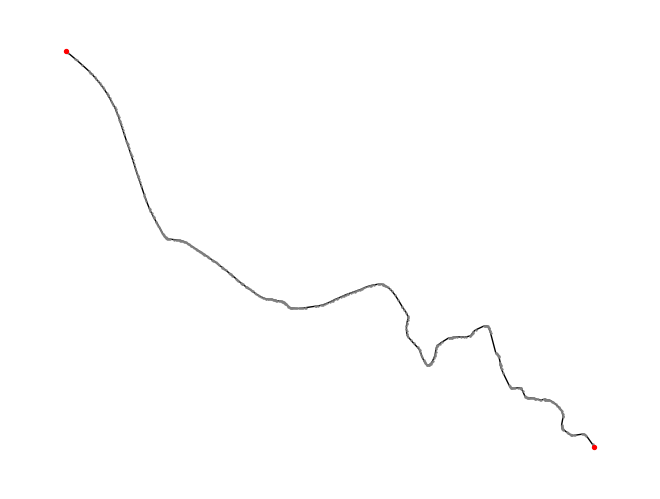

1
Hammersmith & City


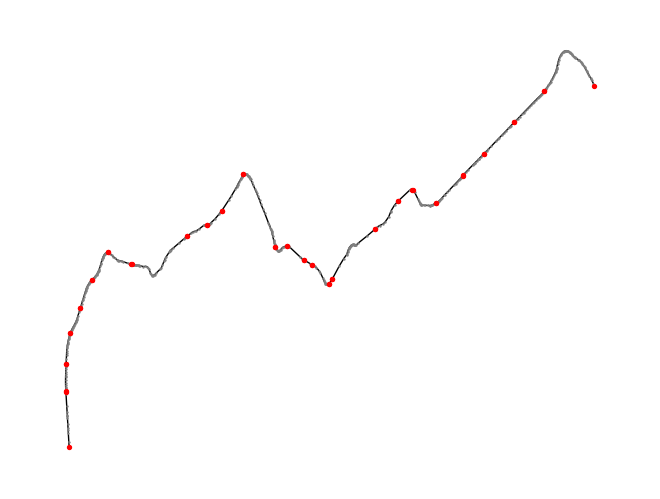

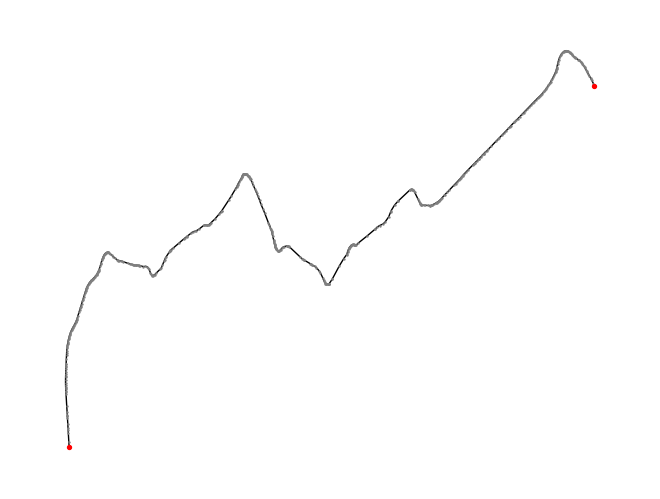

1
Victoria


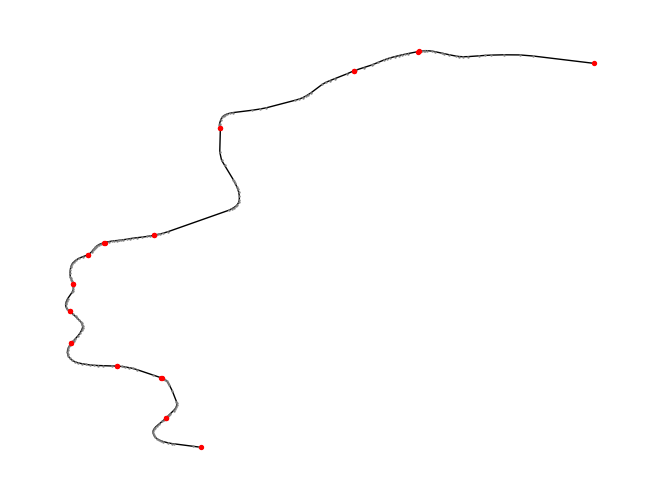

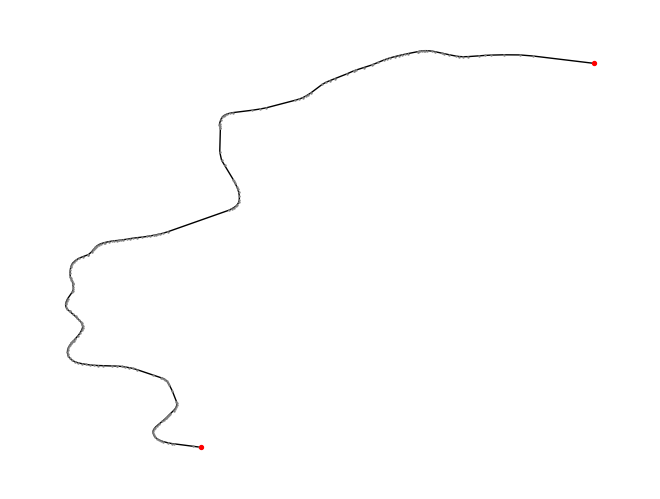

1
Jubilee


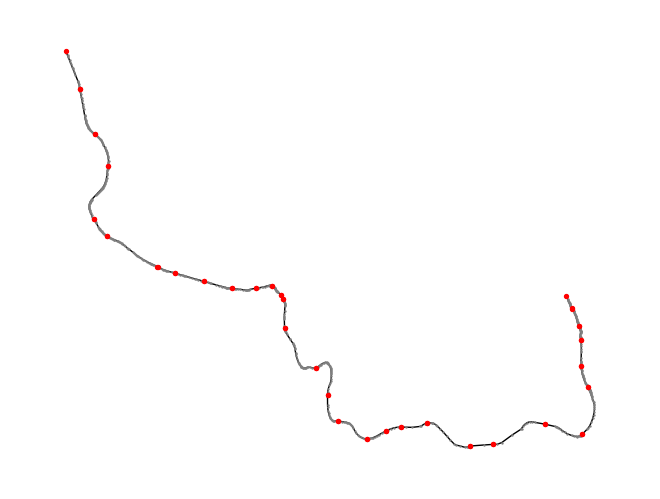

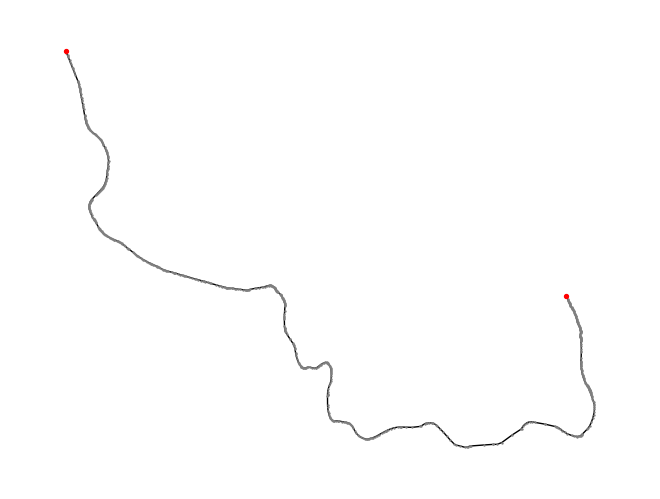

1
London Overground


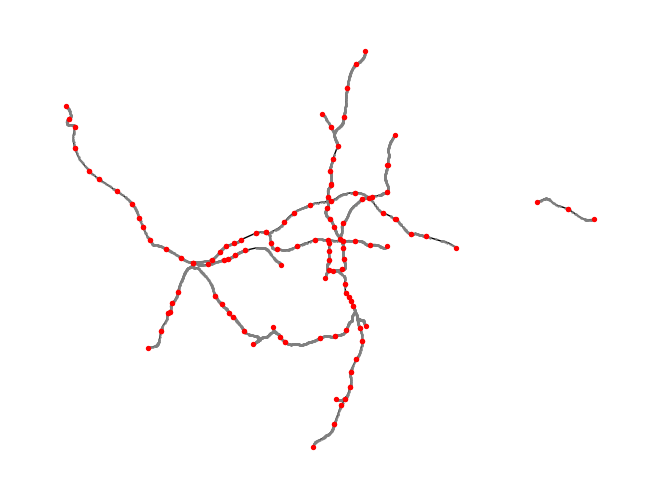

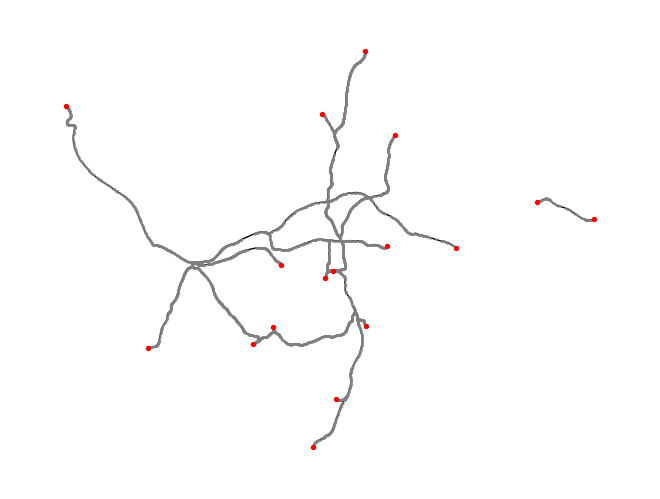

3


In [8]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


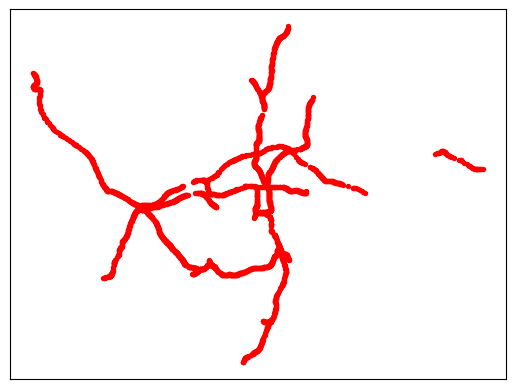

In [9]:
nx.draw_networkx_nodes(G, pos=pos, node_color='red', node_size=8)

In [10]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': shapely.LineString([s_geom, e_geom])
                        })

,line_name,start_id,end_id,geometry
0,Circle,940GZZLUSKS,940GZZLUSSQ,"LINESTRING (526934.428 178814.833, 528075.749 ..."
1,Circle,940GZZLUSKS,940GZZLUGTR,"LINESTRING (526934.428 178814.833, 526199.487 ..."
2,Circle,940GZZLUGTR,940GZZLUHSK,"LINESTRING (526199.487 178841.194, 525543.832 ..."
3,Circle,940GZZLUHSK,940GZZLUGTR,"LINESTRING (525543.832 179548.523, 526199.487 ..."
4,Circle,940GZZLUHSK,940GZZLUNHG,"LINESTRING (525543.832 179548.523, 525282.803 ..."


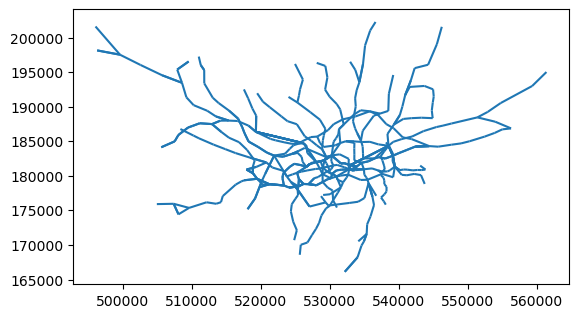

In [11]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

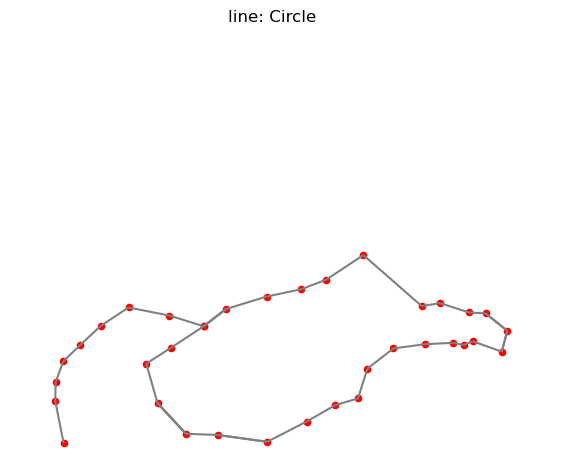

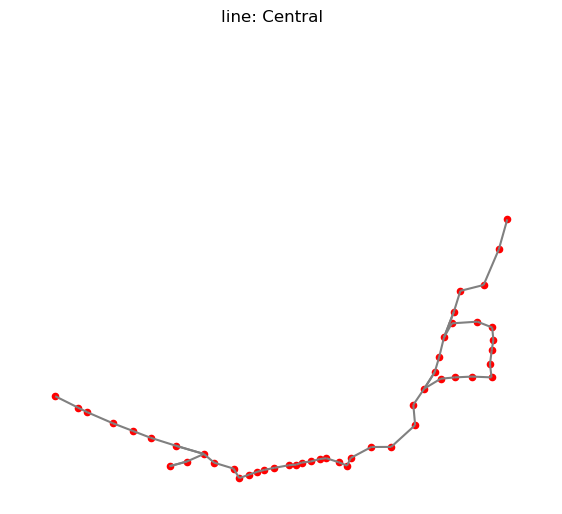

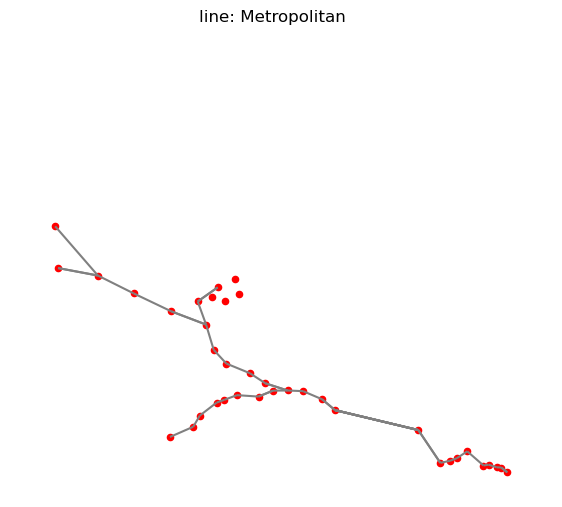

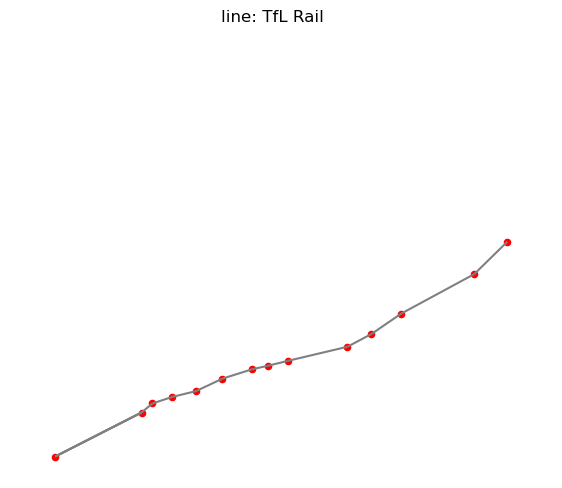

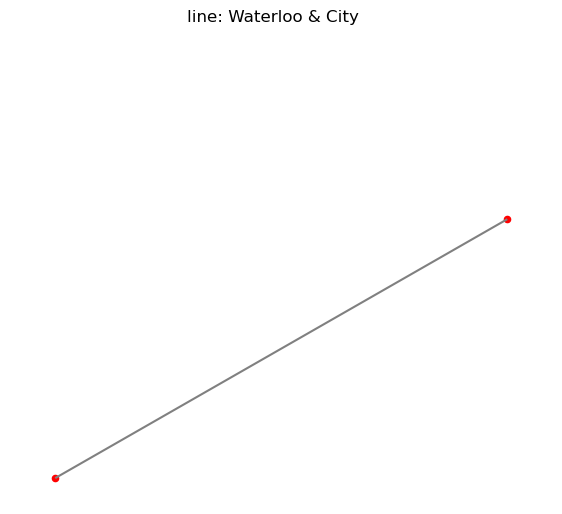

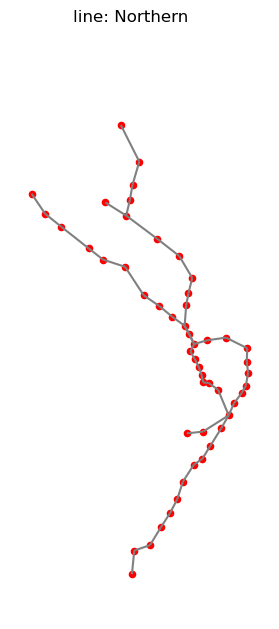

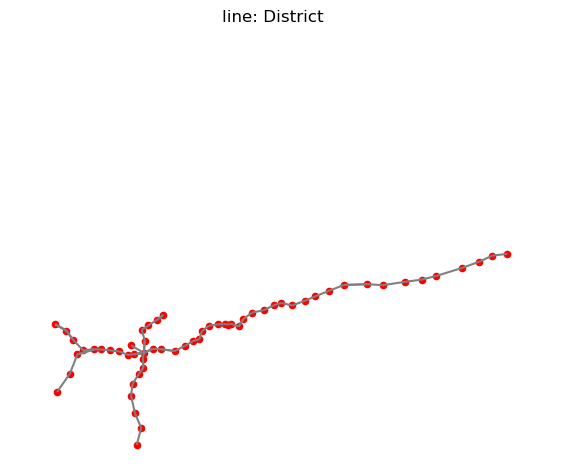

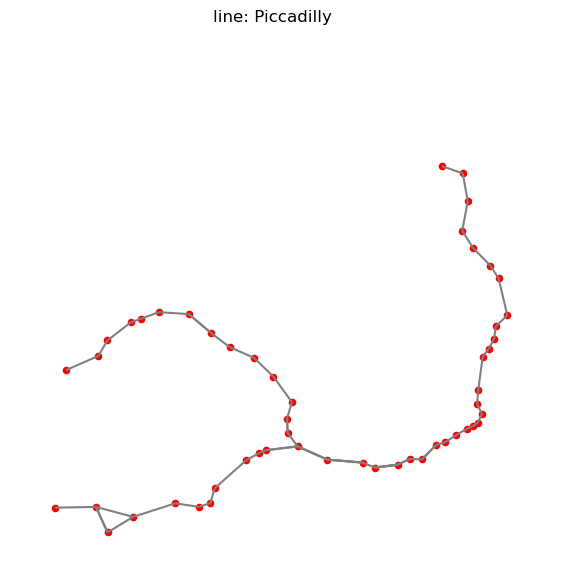

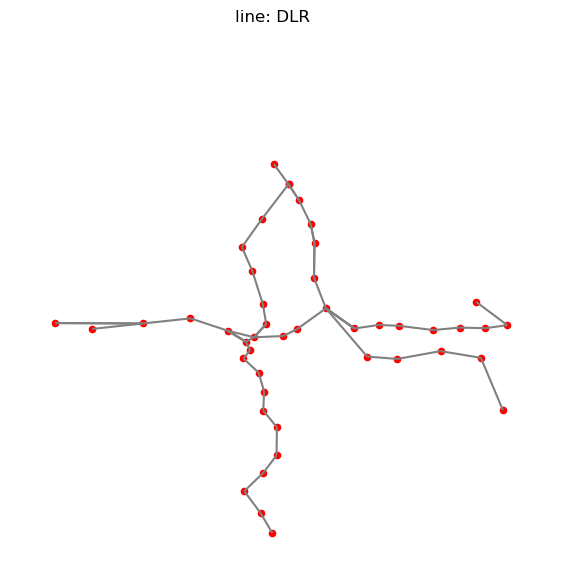

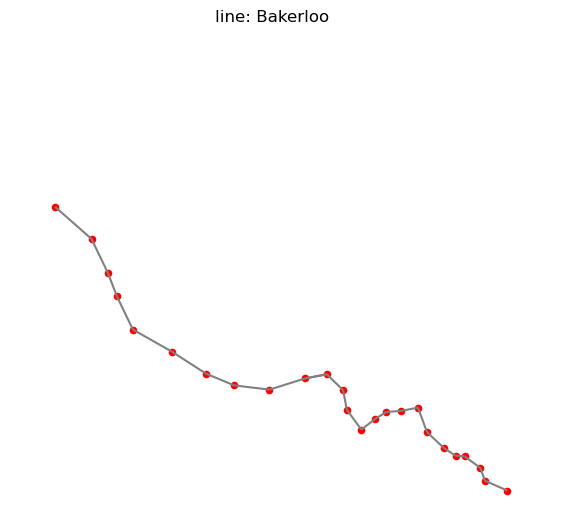

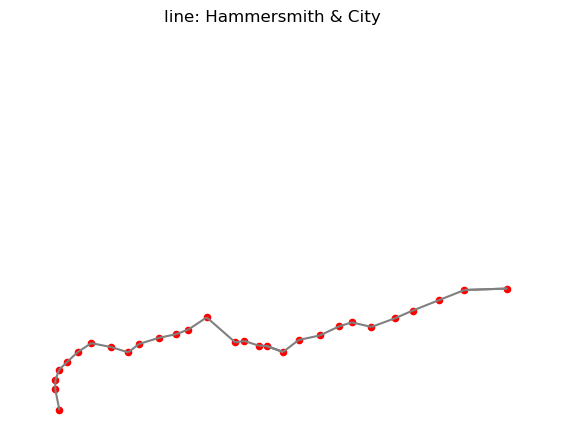

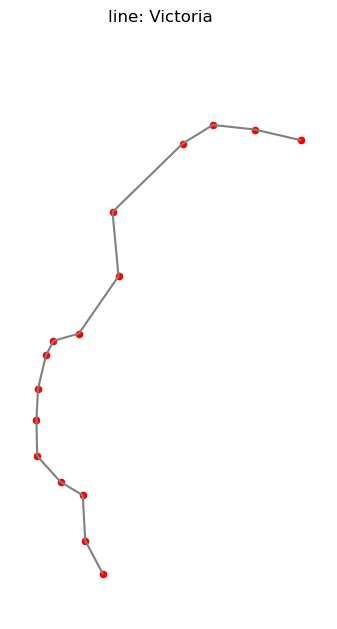

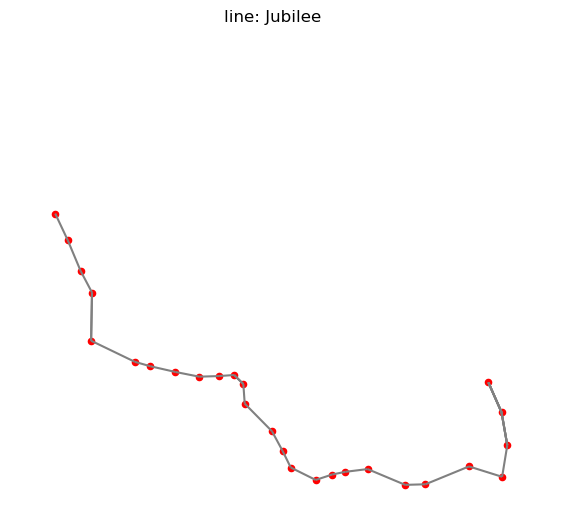

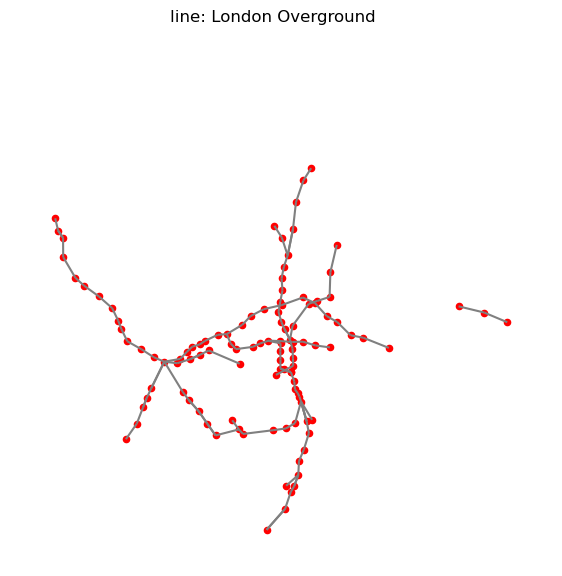

In [12]:
### Add geometry information back into the graph
for line_name in line_names:
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = shapely.LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

### Calculate length and create edge list

,line_name,start_id,end_id,geometry,length
0,Circle,940GZZLUSKS,940GZZLUSSQ,"LINESTRING (526934.428 178814.833, 526935.808 ...",1173.205626
1,Circle,940GZZLUSKS,940GZZLUGTR,"LINESTRING (526934.428 178814.833, 526935.808 ...",751.321633
2,Circle,940GZZLUGTR,940GZZLUHSK,"LINESTRING (526199.487 178841.194, 526200.844 ...",1005.105755
3,Circle,940GZZLUHSK,940GZZLUGTR,"LINESTRING (525543.832 179548.523, 525544.799 ...",1005.105755
4,Circle,940GZZLUHSK,940GZZLUNHG,"LINESTRING (525543.832 179548.523, 525544.799 ...",960.628436


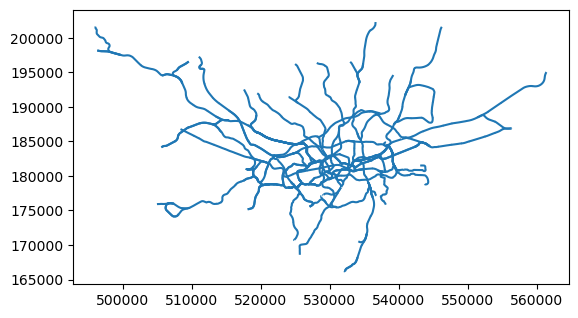

In [13]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

#plot to sanity check
edge_gdf.plot()
edge_gdf.head(5)

In [14]:
#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

### Create Graph

In [15]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'London Overground', 'Bakerloo', 'Circle', 'Piccadilly', 'Hammersmith & City', 'Central', 'Waterloo & City', 'Metropolitan', 'Victoria', 'Jubilee', 'DLR', 'Northern', 'District', 'TfL Rail'}


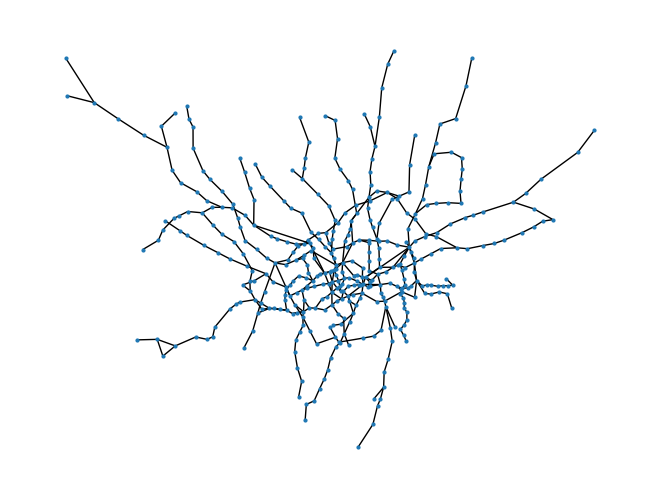

In [16]:
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

The graph will be stored as `G` in a NetworkX format

## Analyse the topological network

Consider the centrality measures of the network we have created.

### Centrality Measures

The following centrality measures are considered:

- degree centrality
- betweenness centrality
- closeness centrality



In [17]:
# calculate degree
degree_london = dict(nx.degree(G))
degree_df = pd.DataFrame.from_dict(degree_london, orient = 'index').rename(columns = {0: 'degree'})
degree_df.sort_values('degree', ascending = False).head(15)

,degree
Stratford,9
Bank and Monument,8
King's Cross St. Pancras,7
Baker Street,7
Waterloo,6
West Ham,6
Canning Town,6
Liverpool Street,6
Earl's Court,6
Green Park,6


In [18]:
# calculate betweenness centrality
between_london = dict(nx.betweenness_centrality(G, weight = 'length', normalized = False))
between_df = pd.DataFrame.from_dict(between_london, orient = 'index').rename(columns = {0: 'betweenness'})
between_df.sort_values('betweenness', ascending = False).head(10)

,betweenness
Bank and Monument,17602.0
King's Cross St. Pancras,16780.0
Stratford,14548.0
Baker Street,13200.0
Oxford Circus,12584.0
Euston,12401.0
Earl's Court,11454.0
Shadwell,11127.0
Waterloo,10407.0
South Kensington,10304.0


In [19]:
# calculate closeness centrality
closeness_london = nx.closeness_centrality(G, distance = 'length')
closeness_df = pd.DataFrame.from_dict(closeness_london, orient = 'index').rename(columns = {0: 'closeness'})

pd.set_option("display.precision", 10)
closeness_df.sort_values('closeness', ascending = False).head(10)

,closeness
Holborn,0.0000792590
King's Cross St. Pancras,0.0000791366
Tottenham Court Road,0.0000789114
Oxford Circus,0.0000788305
Leicester Square,0.0000783760
Piccadilly Circus,0.0000783365
Charing Cross,0.0000783273
Chancery Lane,0.0000782455
Covent Garden,0.0000780952
Embankment,0.0000780168


In [20]:
# set centrality measures as node attributes
nx.set_node_attributes(G, degree_london, 'degree')
nx.set_node_attributes(G, between_london, 'betweenness')
nx.set_node_attributes(G, closeness_london, 'closeness')

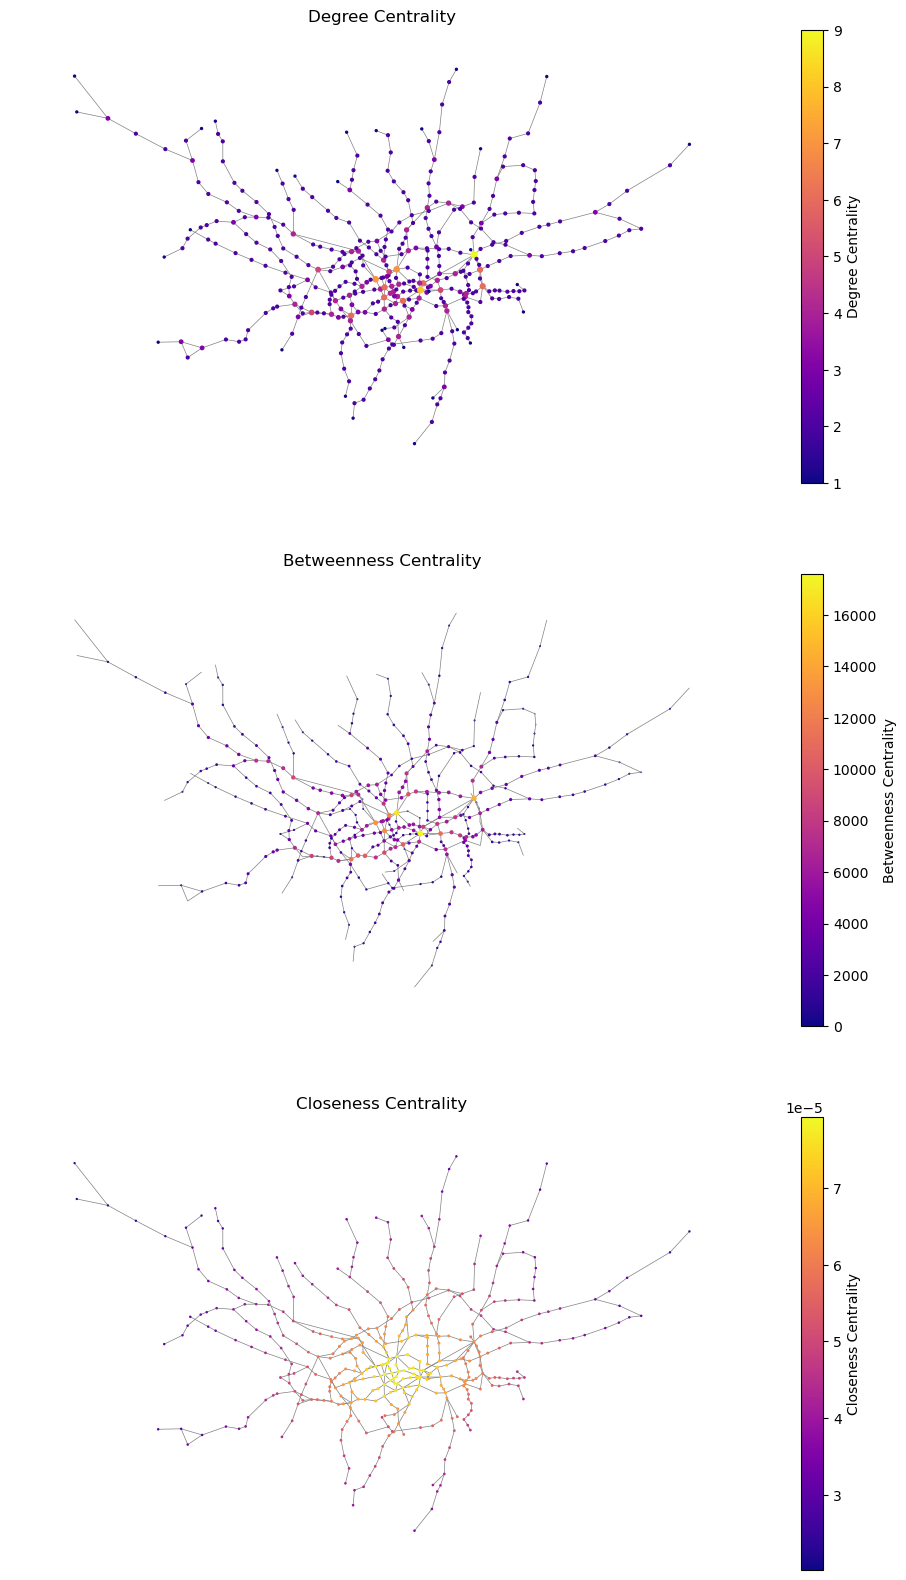

In [21]:
# plot for sanity check

# initalise plot
fig, axes = plt.subplots(3, 1, figsize = (12, 20))

# get position
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}

# draw the network edges for all three as basemap
for ax in axes:
    nx.draw_networkx_edges(G, pos = pos, edge_color = 'gray', width = 0.5, ax = ax)
    ax.axis('off')

# draw degree centrality
degree_plot = nx.draw_networkx_nodes(
    G,
    pos = pos,
    node_color = [c[1]['degree'] for c in G.nodes(data=True)],
    node_size = [c[1]['degree'] * 2 for c in G.nodes(data=True)],
    ax = axes[0],
    cmap = 'plasma'
)

plt.colorbar(
    degree_plot,
    label = 'Degree Centrality',
)

# draw betweenness centrality
between_plot = nx.draw_networkx_nodes(
    G,
    pos = pos,
    node_color = [c[1]['betweenness'] for c in G.nodes(data=True)],
    node_size = [c[1]['betweenness'] / 2000 for c in G.nodes(data=True)],
    ax = axes[1],
    cmap = 'plasma'
)

plt.colorbar(
    between_plot,
    label = 'Betweenness Centrality',
)

# draw closeness centrality
closeness_plot = nx.draw_networkx_nodes(
    G,
    pos = pos,
    node_color = [c[1]['closeness'] for c in G.nodes(data=True)],
    node_size = [c[1]['closeness'] * 20000 for c in G.nodes(data=True)],
    ax = axes[2],
    cmap = 'plasma'
)

plt.colorbar(
    closeness_plot,
    label = 'Closeness Centrality',
)

# set title
axes[0].set_title('Degree Centrality')
axes[1].set_title('Betweenness Centrality')
axes[2].set_title('Closeness Centrality')

plt.show()

### Network performance measures

The following network performance measures are considered:

- average shortest path length
- number of loops


In [22]:
# measures 
nx.average_shortest_path_length(G)

13.545997506234414

In [23]:
nx.global_efficiency(G)

0.10125619359721943

In [24]:
# get the stations to remove
degree_list = degree_df.sort_values('degree', ascending = False).index.to_list()
between_list = between_df.sort_values('betweenness', ascending = False).index.to_list()
closeness_list = closeness_df.sort_values('closeness', ascending = False).index.to_list()

# make into dictionary
station_lists = {
    'degree': degree_list, 
    'betweenness': between_list,
    'closeness': closeness_list
}

# create graph for non-sequential removal
nonseq_removal = {
    'degree': [G.copy()],
    'betweenness': [G.copy()],
    'closeness': [G.copy()]
}

for key in station_lists:
    print(f'Consider {key} centrality')
    for i in np.arange(10):
        G_temp =  nonseq_removal[key][i].copy()
        print(f'{i}: Removing {station_lists[key][i]}')
        G_temp.remove_node(station_lists[key][i])
        nonseq_removal[key].append(G_temp)

Consider degree centrality
0: Removing Stratford
1: Removing Bank and Monument
2: Removing King's Cross St. Pancras
3: Removing Baker Street
4: Removing Waterloo
5: Removing West Ham
6: Removing Canning Town
7: Removing Liverpool Street
8: Removing Earl's Court
9: Removing Green Park
Consider betweenness centrality
0: Removing Bank and Monument
1: Removing King's Cross St. Pancras
2: Removing Stratford
3: Removing Baker Street
4: Removing Oxford Circus
5: Removing Euston
6: Removing Earl's Court
7: Removing Shadwell
8: Removing Waterloo
9: Removing South Kensington
Consider closeness centrality
0: Removing Holborn
1: Removing King's Cross St. Pancras
2: Removing Tottenham Court Road
3: Removing Oxford Circus
4: Removing Leicester Square
5: Removing Piccadilly Circus
6: Removing Charing Cross
7: Removing Chancery Lane
8: Removing Covent Garden
9: Removing Embankment


In [25]:
# sequential removal

# create station lists
seq_station_lists = {
    'degree': [], 
    'betweenness': [],
    'closeness': []
}

# create graph for non-sequential removal
seq_removal = {
    'degree': [G.copy()],
    'betweenness': [G.copy()],
    'closeness': [G.copy()]
}

# degree centrality
print('Degree Centrality')
for i in np.arange(10):
    G_temp = seq_removal['degree'][i].copy()

    # calculate the node to remove - the one with the highest degree centrality
    removing_node = sorted(nx.degree(G_temp), key = lambda x: x[1], reverse = True)[0][0]
    seq_station_lists['degree'].append(removing_node)
    # remove node from graph
    print(f'{i}: Removing {removing_node}')
    G_temp.remove_node(removing_node)
    # add to list
    seq_removal['degree'].append(G_temp)

# betweenness centrality
print('Betweenness Centrality')
for i in np.arange(10):
    G_temp = seq_removal['betweenness'][i].copy()

    # calculate the node to remove - the one with the highest betweenness centrality
    removing_node = sorted(nx.betweenness_centrality(G_temp, weight = 'length').items(), key = lambda x: x[1], reverse = True)[0][0]
    seq_station_lists['betweenness'].append(removing_node)
    # remove node from graph
    print(f'{i}: Removing {removing_node}')
    G_temp.remove_node(removing_node)
    # add to list
    seq_removal['betweenness'].append(G_temp)

# closeness centrality
print('Closeness Centrality')
for i in np.arange(10):
    G_temp = seq_removal['closeness'][i].copy()

    # calculate the node to remove - the one with the highest closeness centrality
    removing_node = sorted(nx.closeness_centrality(G_temp, distance = 'length').items(), key = lambda x: x[1], reverse = True)[0][0]
    seq_station_lists['closeness'].append(removing_node)
    # remove node from graph
    print(f'{i}: Removing {removing_node}')
    G_temp.remove_node(removing_node)
    # add to list
    seq_removal['closeness'].append(G_temp)


Degree Centrality
0: Removing Stratford
1: Removing Bank and Monument
2: Removing Baker Street
3: Removing King's Cross St. Pancras
4: Removing Oxford Circus
5: Removing Earl's Court
6: Removing Canning Town
7: Removing Waterloo
8: Removing Turnham Green
9: Removing Green Park
Betweenness Centrality
0: Removing Bank and Monument
1: Removing King's Cross St. Pancras
2: Removing Canada Water
3: Removing West Hampstead
4: Removing Earl's Court
5: Removing Oxford Circus
6: Removing Shepherd's Bush
7: Removing Baker Street
8: Removing Acton Town
9: Removing Stratford
Closeness Centrality
0: Removing Holborn
1: Removing King's Cross St. Pancras
2: Removing Embankment
3: Removing Waterloo
4: Removing London Bridge
5: Removing West Hampstead
6: Removing Clapham Junction
7: Removing Mile End
8: Removing Stratford
9: Removing Notting Hill Gate


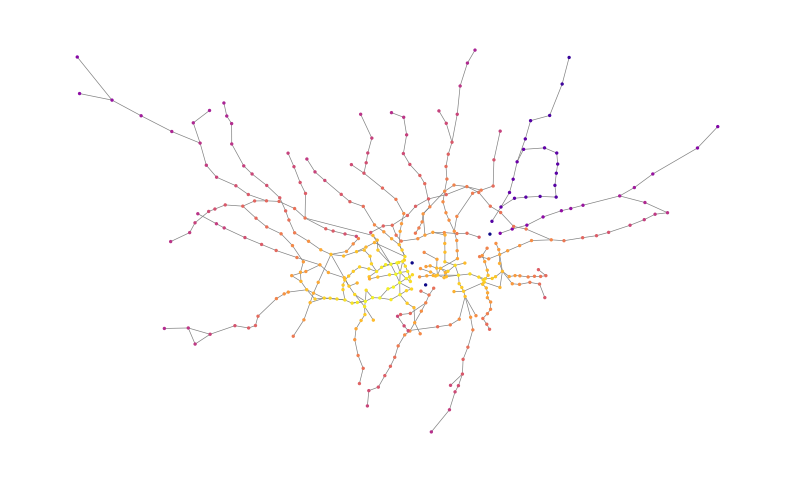

In [108]:
# sanity check closeness centrality

G_number = 10

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
nx.draw_networkx_edges(seq_removal['closeness'][G_number], pos = pos, edge_color = 'gray', width = 0.5, ax = ax)
ax.axis('off')

nx.draw_networkx_nodes(
    seq_removal['closeness'][G_number],
    pos = pos,
    node_color = list(nx.closeness_centrality(seq_removal['closeness'][G_number], distance = 'length').values()),
    node_size = 2,
    ax = ax,
    cmap = 'plasma'
)

In [26]:
# define global efficiency considering weight 
def global_efficiency_weighted(G, weight=None):
    n = len(G)
    denom = n * (n - 1)
    g_eff = 0
    if denom != 0:
        # calculate distance for all pairs, considering the distance

        all_shortest_paths = dict(nx.all_pairs_dijkstra_path_length(G, weight=weight))
        for source in all_shortest_paths:
            for target, distance in all_shortest_paths[source].items():
                if distance > 0:
                    g_eff += 1 / distance

        g_eff /= denom    
    return g_eff

print(global_efficiency_weighted(G))
print(nx.global_efficiency(G))


0.10125619359721943
0.10125619359721943


In [27]:
# calculate the measures
nonseq_measures = pd.DataFrame(nonseq_removal)
seq_measures = pd.DataFrame(seq_removal)

for df in [nonseq_measures, seq_measures]:
    for c in df.columns.to_list():
        df[f'{c}_ncc'] = df.apply(lambda x: nx.number_connected_components(x[c]), axis = 1)
        df[f'{c}_lcc'] = df.apply(lambda x: [len(c) for c in sorted(nx.connected_components(x[c]), key = len, reverse = True)][0], axis = 1)
        df[f'{c}_ave_length'] = df.apply(
            lambda x: (nx.average_shortest_path_length(x[c]) if nx.number_connected_components(x[c]) == 1 else np.nan), axis = 1
        )
        df[f'{c}_efficiency'] = df.apply(
            lambda x: global_efficiency_weighted(x[c], weight = 'length'),
            axis = 1
        )


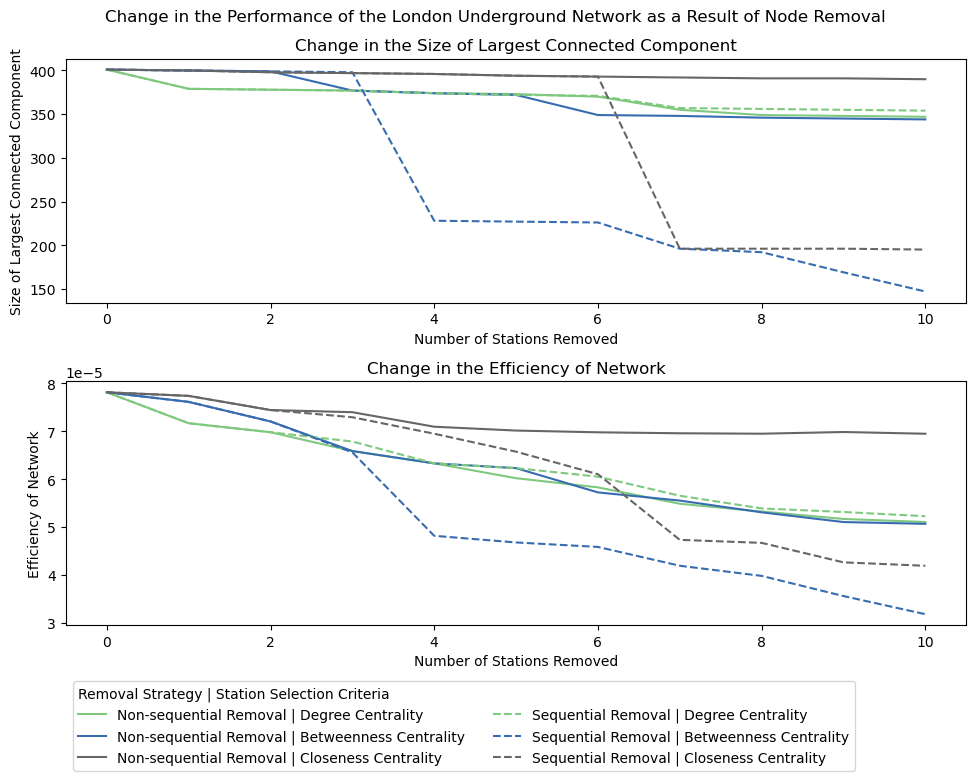

In [149]:
# plot change in largest connecting component

# initialise plot
fig, axes = plt.subplots(2, 1, figsize = (10, 8))

# set color map
color_palette = 'Accent'


# ----- Plot Largest Connected Component -----

# plot sequential removal

# plot nonsequential removal
nonseq_measures.plot(
    y = ['degree_lcc', 'betweenness_lcc', 'closeness_lcc'],
    ax = axes[0],
    cmap = color_palette,
    legend = False
)
seq_measures.plot(
    y = ['degree_lcc', 'betweenness_lcc', 'closeness_lcc'],
    ax = axes[0],
    style = '--',
    cmap = color_palette,
    legend = False
)

# set axis labels
axes[0].set_xlabel('Number of Stations Removed')
axes[0].set_ylabel('Size of Largest Connected Component')
axes[0].set_title('Change in the Size of Largest Connected Component')

# ----- Plot Efficiency -----

# plot sequential removal
# plot non-sequential removal
nonseq_measures.plot(
    y = ['degree_efficiency', 'betweenness_efficiency', 'closeness_efficiency'],
    ax = axes[1],
    cmap = color_palette,
    label = ['Non-sequential Removal | Degree Centrality', 'Non-sequential Removal | Betweenness Centrality', 'Non-sequential Removal | Closeness Centrality']
)

seq_measures.plot(
    y = ['degree_efficiency', 'betweenness_efficiency', 'closeness_efficiency'],
    ax = axes[1],
    style = '--',
    cmap = color_palette,
    label = ['Sequential Removal | Degree Centrality', 'Sequential Removal | Betweenness Centrality', 'Sequential Removal | Closeness Centrality']
)

# set axis labels
axes[1].set_xlabel('Number of Stations Removed')
axes[1].set_ylabel('Efficiency of Network')
axes[1].set_title('Change in the Efficiency of Network')

# set legend
axes[1].legend(
    title = 'Removal Strategy | Station Selection Criteria', 
    ncols = 2, alignment = 'left',
    loc = 'upper left', bbox_to_anchor = (0, -0.2)
)

# set title
plt.suptitle('Change in the Performance of the London Underground Network as a Result of Node Removal')

# tight layout
plt.tight_layout()

# show plot
# plt.show()
plt.savefig('documents/img/node_removal_measures.png', bbox_inches = 'tight')

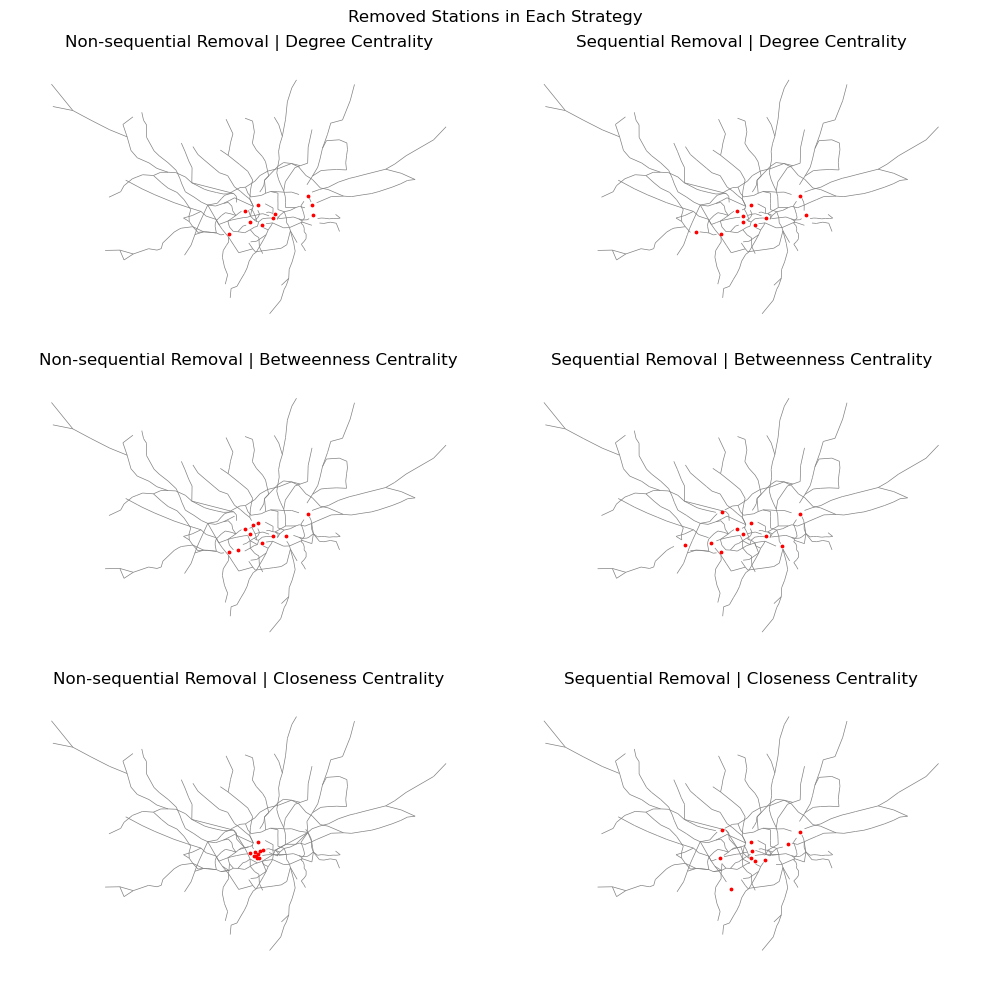

In [151]:
# plot the outcome graph

# plot for sanity check

# initalise plot
fig, axes = plt.subplots(3, 2, figsize = (10, 10))

centrality_measures = ['degree', 'betweenness', 'closeness']
dfs = [nonseq_measures, seq_measures]

# draw the graphs
# the 3 rows refer to centrality measures
# the 2 colomns refer to the strategy
for i, rows in enumerate(axes):
    for j, ax in enumerate(rows):
        # network in question
        G_temp = dfs[j][centrality_measures[i]][10]
        # draw the network edges for all three as basemap
        nx.draw_networkx_edges(G_temp, pos = pos, edge_color = 'gray', width = 0.5, ax = ax)
        ax.axis('off')

        # draw all nodes
        removed_nodes_plot = nx.draw_networkx_nodes(
            G,
            pos = pos,
            nodelist = [n for n in list(G) if n not in list(G_temp)],
            node_color = 'red',
            node_size = 3,
            ax = ax,
        )

        # set title
        ax.set_title(f"{'Non-s' if j == 0 else 'S'}equential Removal | {centrality_measures[i].capitalize()} Centrality")

# plot title
plt.suptitle('Removed Stations in Each Strategy')

# tight layout
plt.tight_layout()

# plot figure
plt.show()